In [11]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms, utils
import torchvision.datasets as dsets
from sklearn.metrics import f1_score
from skimage import io, transform
import matplotlib.image as mpimg
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import warnings
import torch
import time
import os

warnings.filterwarnings("ignore")

In [2]:
def to_gpu(x):
    return x.cuda() if torch.cuda.is_available() else x

# Define Data Loading

In [3]:
class costum_images_dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(os.listdir(self.root_dir))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, sorted(os.listdir(self.root_dir))[idx])
        image = io.imread(img_name)
        label = img_name[-5] # get the label of a given image
        sample = (image, int(label))

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample[0], sample[1] 

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        return (img, label)


class ToTensor(object):
    def __call__(self, sample):
        image, label = sample[0], sample[1] 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1)).astype(float)
        return (torch.from_numpy(image), torch.tensor(label))

In [5]:
train_dataset = costum_images_dataset(root_dir='/StudentData/train/', transform=transforms.Compose([Rescale((64,64)),ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 128, shuffle=True, num_workers=2)

test_dataset = costum_images_dataset(root_dir='/StudentData/test/', transform=transforms.Compose([Rescale((64,64)),ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 128, shuffle=False, num_workers=2)

# Define Network #2

In [6]:
class CNN_2(nn.Module):
    def __init__(self):
        super(CNN_2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=5, padding=2),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, padding=2),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(8 * 8 * 512, 2)
        self.dropout = nn.Dropout(p=0.2)
        self.logsoftmax = nn.LogSoftmax()
        self.softmax = nn.Softmax()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out) 
        out = self.layer3(out) 
        out = self.dropout(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)  
        out = self.dropout(out)
        out = self.fc(out) 

        return self.softmax(out)

In [7]:
cnn = CNN_2()
cnn = to_gpu(cnn)

criterion = nn.NLLLoss()
criterion = to_gpu(criterion)

print('number of parameters: ', sum(param.numel() for param in cnn.parameters()))
print(f'Num of trainable parameters : {sum(p.numel() for p in cnn.parameters() if p.requires_grad)}')

number of parameters:  1814866
Num of trainable parameters : 1814866


In [8]:
my_max_model = to_gpu(CNN_2())
my_max_score = 95.974

# Model Training

In [ ]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001, weight_decay=0.001)

train_errors_per_epoch = []
train_loss_per_epoch = []
train_f1_per_epoch = []

test_errors_per_epoch = []
test_loss_per_epoch = []
test_f1_per_epoch = []

cnn.train()
for epoch in range(50):
    start = time.time()
    epoch_loss = 0.0
    cnn.train()
    for i, (images, labels) in enumerate(train_loader):
        images = to_gpu(images)
        labels = to_gpu(labels)
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        images = images.float()
        outputs = cnn(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    #end of epoch
    cnn.eval() 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = to_gpu(images)
        images = images.float()
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum()
    print(time.time() - start, ' epoch is:', epoch+1 , 'Test Accuracy of the model is:', float((100 * correct.item() / total)))
    if  float((100 * correct.item() / total)) > my_max_score:
        my_max_score = float((100 * correct.item() / total))
        my_max_model = cnn
    
    #train
    correct = 0
    total = 0    
    y_pred = []
    y_true = []
    for images, labels in train_loader:
        images = to_gpu(images)
        images = images.float()
        labels = to_gpu(labels)
        
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        y_pred += [x.item() for x in predicted] # save all predictions
        y_true += [x.item() for x in labels] # save all true values
    
    train_loss_per_epoch.append(epoch_loss / len(train_loader )) # save loss so far
    train_errors_per_epoch.append( 1 - float(correct.item()) / float(total)) # save error so far
    train_f1_per_epoch.append(f1_score(y_true, y_pred, average='binary'))  # save f1 so far
    
    #test
    temp_test_loss = 0.0
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = to_gpu(images)
        images = images.float()
        labels = to_gpu(labels)
        outputs = cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        loss = criterion(outputs, labels)
        temp_test_loss += loss.item()
        y_pred += [x.item() for x in predicted] # save all predictions
        y_true += [x.item() for x in labels] # save all true values
        
    test_loss_per_epoch.append(float(temp_test_loss)/float(len(test_loader)))  # save loss so far
    test_errors_per_epoch.append( 1 -  float(correct.item()) / float(total)) # save error so far
    test_f1_per_epoch.append(f1_score(y_true, y_pred, average='binary')) # save f1 so far

In [14]:
# torch.save(cnn.state_dict(), 'cnn_best_v2.pkl') # 0.9631190727081138

# Plot Graphs

### Errors per Epoch

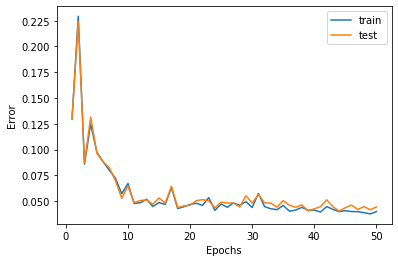

In [16]:
epoch_list = list(range(1,50 + 1))

plt.plot(epoch_list,train_errors_per_epoch, label='train')
plt.plot(epoch_list,test_errors_per_epoch,label='test')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()

### Loss per Epoch

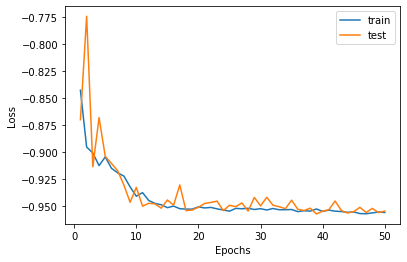

In [17]:
plt.plot(epoch_list,train_loss_per_epoch, label='train')
plt.plot(epoch_list,test_loss_per_epoch,label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### F1 per Epoch

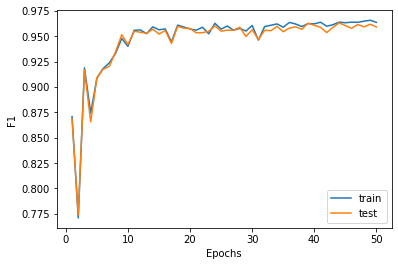

In [18]:
plt.plot(epoch_list,train_f1_per_epoch, label='train')
plt.plot(epoch_list,test_f1_per_epoch, label='test')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()

### ROC AUC CURVE

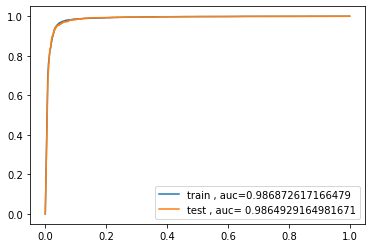

In [19]:
from sklearn import metrics
import matplotlib.pyplot as plt

#ROC for train data
y_prob = []
y_true = []
for images, labels in train_loader:
    images = to_gpu(images)
    images = images.float()
    labels = to_gpu(labels)
    outputs = cnn(images)
    y_prob += outputs.tolist() # save all predictions
    y_true += [x.item() for x in labels] # save all true values
    
#ROC for test data
y_test_prob = []
y_test_true = []
for images, labels in test_loader:
    images = to_gpu(images)
    images = images.float()
    labels = to_gpu(labels)
    outputs = cnn(images)
    y_test_prob += outputs.tolist() # save all predictions
    y_test_true += [x.item() for x in labels] # save all true values
    
fpr, tpr, _ = metrics.roc_curve(y_true, [x[1] for x in y_prob])
auc = metrics.roc_auc_score(y_true,  [x[1] for x in y_prob])
plt.plot(fpr,tpr,label="train , auc=" + str(auc))

fpr_t, tpr_t, _ = metrics.roc_curve(y_test_true, [x[1] for x in y_test_prob])
auc_t = metrics.roc_auc_score(y_test_true,  [x[1] for x in y_test_prob])
plt.plot(fpr_t, tpr_t,label="test , auc= " + str(auc_t))

plt.legend(loc=4)
plt.show()